# Analisis de series de tiempo

Integrantes del trabajo final

Castillo Sebastian (a2004)
Corti Gaston (a2005)

# Ingesta de la informacion

La informacion se obtiene via API del sitio de gobierno la ciudad [Los Angeles](https://data.lacity.org/Public-Safety/Traffic-Collision-Data-from-2010-to-Present/d5tf-ez2w/about_data)

El dataset refleja los incidentes de transito en la Ciudad de Los Angeles desde 2010 hasta marzo de 2025.

Los datos son transcritos de los reportes originales que son elaborados en papel.

El objetivo es desarrollar un modelo que permita estimar la cantidad de incidentes de transito que ocurriran en el futuro.

## Ingesta de informacion via API

In [2]:
import requests as rq
import json
import pandas as pd
import time

#---------------------------------------------------------
# TRAFIC COLLISION DATA FROM 2010 TO PRESENT (Los Angeles)
#---------------------------------------------------------

# 1) Ingesta de datos desde via API Endpoint

api_ep_la_collisions = 'https://data.lacity.org/resource/d5tf-ez2w.json'

LIMIT = 50000 # Maximum allowed per request (SODA 2.0)
MAX_RETRIES = 3
RETRY_DELAY = 10 # Seconds to wait between attempts

# Storage for the data
la_collisions_data = []
offset = 0
total_retrieved = 0
EXPECTED_TOTAL_ROWS = 621677

print("Starting data retrieval...")

while True:
    retries = 0
    success = False
    last_error_message = ""

    while retries < MAX_RETRIES and not success:
        try:
            params = {'$limit': LIMIT, '$offset': offset}
            response = rq.get(api_ep_la_collisions, params=params)

            if response.status_code == 200:
                chunk = response.json()
                # The condition 'if not chunk:' is redundant as len(chunk) < LIMIT will cover it
                # if the chunk is empty.

                la_collisions_data.extend(chunk)
                retrieved = len(chunk)
                total_retrieved += retrieved
                print(f"✅ Partially ingested {retrieved} rows (Total: {total_retrieved})")
                offset += retrieved
                success = True

            else:
                last_error_message = f"HTTP Error {response.status_code}: {response.text}"
                print(f"⚠️ {last_error_message}. Retrying...")
                retries += 1
                if retries < MAX_RETRIES:
                    time.sleep(RETRY_DELAY)

        except Exception as e:
            last_error_message = f"Exception: {str(e)}"
            print(f"⚠️ {last_error_message}. Retrying...")
            retries += 1
            if retries < MAX_RETRIES:
                time.sleep(RETRY_DELAY)

    if not success:
        print(f"❌ Failed after {MAX_RETRIES} attempts. Stopping. Last error: {last_error_message}")
        break

    # If the retrieved chunk is less than the LIMIT, it means we've reached the end of the data.
    if len(chunk) < LIMIT:
        break

print(f"✅ Final ingestion completed: {len(la_collisions_data)} rows retrieved.")

# Added: Optional: Verify the total number of rows
if len(la_collisions_data) == EXPECTED_TOTAL_ROWS:
    print(f"🎉 Successfully retrieved all {EXPECTED_TOTAL_ROWS} expected rows.")
else:
    print(f"❗ Warning: Expected {EXPECTED_TOTAL_ROWS} rows, but retrieved {len(la_collisions_data)} rows.")

Starting data retrieval...
✅ Partially ingested 50000 rows (Total: 50000)
✅ Partially ingested 50000 rows (Total: 100000)
✅ Partially ingested 50000 rows (Total: 150000)
✅ Partially ingested 50000 rows (Total: 200000)
✅ Partially ingested 50000 rows (Total: 250000)
✅ Partially ingested 50000 rows (Total: 300000)
✅ Partially ingested 50000 rows (Total: 350000)
✅ Partially ingested 50000 rows (Total: 400000)
✅ Partially ingested 50000 rows (Total: 450000)
✅ Partially ingested 50000 rows (Total: 500000)
✅ Partially ingested 50000 rows (Total: 550000)
✅ Partially ingested 50000 rows (Total: 600000)
✅ Partially ingested 21677 rows (Total: 621677)
✅ Final ingestion completed: 621677 rows retrieved.
🎉 Successfully retrieved all 621677 expected rows.


## Transformacion de los datos en un dataframe

In [3]:
#Transformamos los datos en dataframe utilizando la funcion json_normalize

df_la_collisions = pd.json_normalize(la_collisions_data)

df_la_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621677 entries, 0 to 621676
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   dr_no                        621677 non-null  object
 1   date_rptd                    621677 non-null  object
 2   date_occ                     621677 non-null  object
 3   time_occ                     621677 non-null  object
 4   area                         621677 non-null  object
 5   area_name                    621677 non-null  object
 6   rpt_dist_no                  621677 non-null  object
 7   crm_cd                       621677 non-null  object
 8   crm_cd_desc                  621677 non-null  object
 9   mocodes                      534353 non-null  object
 10  vict_age                     533483 non-null  object
 11  vict_sex                     610980 non-null  object
 12  vict_descent                 610029 non-null  object
 13  premis_cd     

## Preprocesamiento de datos

In [4]:
import pandas as pd

df = df_la_collisions

# Mostrar las primeras filas del dataset
df.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,crm_cd,crm_cd_desc,mocodes,...,cross_street,:@computed_region_qz3q_ghft,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_kqwf_mjcx,:@computed_region_2dna_qi2s,location_1.latitude,location_1.longitude,location_1.human_address
0,212013850,2021-09-03T00:00:00.000,2021-09-02T00:00:00.000,2335,20,Olympic,2021,997,TRAFFIC COLLISION,3004 3027 3034 4027 3036 3101 3401 3701,...,6TH ST,22722,588,875,36,7,86,34.063,-118.3141,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
1,221417787,2022-10-17T00:00:00.000,2022-10-17T00:00:00.000,1620,14,Pacific,1406,997,TRAFFIC COLLISION,4027 3011 3028 3034 3037 3101 3401 3701,...,MOTOR AV,23451,881,1358,9,6,74,34.029,-118.4113,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
2,221418141,2022-10-26T00:00:00.000,2022-10-26T00:00:00.000,1135,14,Pacific,1434,997,TRAFFIC COLLISION,4027 3011 3025 3034 3037 3101 3401 3701,...,ROSEWOOD AV,24031,891,855,10,10,27,34.0052,-118.4478,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
3,222017859,2022-12-01T00:00:00.000,2022-12-01T00:00:00.000,0230,20,Olympic,2044,997,TRAFFIC COLLISION,3003 0913 3026 3035 3037 3101 3401 3701 4020,...,SAN MARINO ST,22723,607,647,NaN,12,89,34.0545,-118.3009,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
4,190319651,2019-08-24T00:00:00.000,2019-08-24T00:00:00.000,0450,03,Southwest,0356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,...,NORMANDIE AV,22724,691,916,7,14,32,34.0255,-118.3002,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."


In [9]:
# Eliminar columnas irrelevantes para modelado temporal
columnas_a_eliminar = [
    'dr_no', 'rpt_dist_no', 'crm_cd', 'crm_cd_desc',
    'cross_street', 'location_1.human_address'
]
# Eliminar columnas con nombres tipo @computed
columnas_a_eliminar += [col for col in df.columns if col.startswith(':@computed')]

# Aplicar eliminación
df_limpio = df.drop(columns=columnas_a_eliminar)

# Convertir columnas de fecha a datetime
df_limpio['date_rptd'] = pd.to_datetime(df_limpio['date_rptd'], errors='coerce')
df_limpio['date_occ'] = pd.to_datetime(df_limpio['date_occ'], errors='coerce')

# Revisar valores nulos
nulos = df_limpio.isnull().sum()

# Mostrar resumen del dataframe limpio y los nulos encontrados
df_limpio.info(), nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621677 entries, 0 to 621676
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date_rptd             621677 non-null  datetime64[ns]
 1   date_occ              621677 non-null  datetime64[ns]
 2   time_occ              621677 non-null  object        
 3   area                  621677 non-null  object        
 4   area_name             621677 non-null  object        
 5   mocodes               534353 non-null  object        
 6   vict_age              533483 non-null  object        
 7   vict_sex              610980 non-null  object        
 8   vict_descent          610029 non-null  object        
 9   premis_cd             620718 non-null  object        
 10  premis_desc           620717 non-null  object        
 11  location              621677 non-null  object        
 12  location_1.latitude   621677 non-null  object        
 13 

(None,
 date_rptd                   0
 date_occ                    0
 time_occ                    0
 area                        0
 area_name                   0
 mocodes                 87324
 vict_age                88194
 vict_sex                10697
 vict_descent            11648
 premis_cd                 959
 premis_desc               960
 location                    0
 location_1.latitude         0
 location_1.longitude        0
 dtype: int64)

In [11]:
# Asegurarse de que vict_age sea numérico
df_limpio['vict_age'] = pd.to_numeric(df_limpio['vict_age'], errors='coerce')

# Imputar vict_age con la mediana
df_limpio['vict_age'] = df_limpio['vict_age'].fillna(df_limpio['vict_age'].median())

# Imputar categóricas con 'Unknown'
df_limpio['vict_sex'] = df_limpio['vict_sex'].fillna('Unknown')
df_limpio['vict_descent'] = df_limpio['vict_descent'].fillna('Unknown')
df_limpio['premis_desc'] = df_limpio['premis_desc'].fillna('Unknown')

# Imputar premis_cd con la moda
df_limpio['premis_cd'] = df_limpio['premis_cd'].fillna(df_limpio['premis_cd'].mode()[0])

# Eliminar mocodes si no se necesita
df_limpio = df_limpio.drop(columns=['mocodes'])

# Verificar que no haya nulos
nulos_post = df_limpio.isnull().sum()
print(nulos_post)

date_rptd               0
date_occ                0
time_occ                0
area                    0
area_name               0
vict_age                0
vict_sex                0
vict_descent            0
premis_cd               0
premis_desc             0
location                0
location_1.latitude     0
location_1.longitude    0
dtype: int64


In [14]:
import numpy as np

# Seleccionar columnas numéricas a revisar
columnas_numericas = ['time_occ', 'vict_age', 'location_1.latitude', 'location_1.longitude']

for col in columnas_numericas:
    df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce')

# Aplicar detección de outliers usando IQR
outliers_info = {}

for col in columnas_numericas:
    Q1 = df_limpio[col].dropna().quantile(0.25)
    Q3 = df_limpio[col].dropna().quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df_limpio[(df_limpio[col] < limite_inferior) | (df_limpio[col] > limite_superior)]
    outliers_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Limite inferior': limite_inferior,
        'Limite superior': limite_superior,
        'Cantidad outliers': len(outliers)
    }

import pandas as pd
pd.DataFrame(outliers_info).T

,Q1,Q3,IQR,Limite inferior,Limite superior,Cantidad outliers
time_occ,930.0000,1825.0000,895.0000,-412.50000,3167.50000,0.0
vict_age,30.0000,49.0000,19.0000,1.50000,77.50000,16954.0
location_1.latitude,34.0172,34.1758,0.1586,33.77930,34.41370,12072.0
location_1.longitude,-118.4396,-118.2805,0.1591,-118.67825,-118.04185,1001.0


In [15]:
# Crear una copia para filtrar los outliers
df_filtrado = df_limpio.copy()

# Aplicar filtros por cada columna con outliers
for col in ['vict_age', 'location_1.latitude', 'location_1.longitude']:
    Q1 = df_filtrado[col].quantile(0.25)
    Q3 = df_filtrado[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtrado = df_filtrado[(df_filtrado[col] >= lower_bound) & (df_filtrado[col] <= upper_bound)]

df_filtrado.shape

(593193, 13)

#Preparación del dataset para entrenamiento en 3 modelos: LSTM, Random Forest y Gradient Boosting


---



In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
df = df_filtrado

In [18]:
df['date_occ'] = pd.to_datetime(df['date_occ'])

In [19]:
# Filtrar por Hollywood y agrupar por fecha
df = df[df['area_name'] == 'Hollywood']
daily = df.groupby('date_occ').size().reset_index(name='collision_count')

# Crear features
daily['dayofyear'] = daily['date_occ'].dt.dayofyear
daily['weekday'] = daily['date_occ'].dt.weekday
daily['year'] = daily['date_occ'].dt.year
daily['lag_1'] = daily['collision_count'].shift(1)
daily['lag_2'] = daily['collision_count'].shift(2)
daily['rolling_mean_3'] = daily['collision_count'].rolling(3).mean()

In [20]:
# Limpiar NaNs
daily = daily.dropna()

# Variables
X = daily[['dayofyear', 'weekday', 'year', 'lag_1', 'lag_2', 'rolling_mean_3']]
y = daily['collision_count']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [24]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)

In [25]:
#Escalado
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, window):
        self.X, self.y = [], []
        for i in range(len(X) - window):
            self.X.append(X[i:i+window])
            self.y.append(y[i+window])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32).view(-1, 1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

window = 7
dataset = TimeSeriesDataset(X_scaled, y.values, window)
train_size = int(len(dataset) * 0.8)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [26]:
#Implementación LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel(input_size=X.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [27]:
#Implementación LSTM con early stopping y loss history para hacer la curva de loss vs epoch
loss_history = []
best_loss = float('inf')
counter = 0

for epoch in range(200):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)  # Guardar el loss por época
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= 5:
            print("Early stopping")
            break

model.load_state_dict(best_model_state)

Epoch 1, Loss: 9.9302
Epoch 2, Loss: 6.4899
Epoch 3, Loss: 6.4473
Epoch 4, Loss: 6.4103
Epoch 5, Loss: 6.3863
Epoch 6, Loss: 6.3754
Epoch 7, Loss: 6.3654
Epoch 8, Loss: 6.3416
Epoch 9, Loss: 6.3227
Epoch 10, Loss: 6.3139
Epoch 11, Loss: 6.3066
Epoch 12, Loss: 6.2949
Epoch 13, Loss: 6.2805
Epoch 14, Loss: 6.2684
Epoch 15, Loss: 6.2469
Epoch 16, Loss: 6.2199
Epoch 17, Loss: 6.2037
Epoch 18, Loss: 6.1931
Epoch 19, Loss: 6.1847
Epoch 20, Loss: 6.1763
Epoch 21, Loss: 6.1679
Epoch 22, Loss: 6.1567
Epoch 23, Loss: 6.1460
Epoch 24, Loss: 6.1381
Epoch 25, Loss: 6.1459
Epoch 26, Loss: 6.1247
Epoch 27, Loss: 6.1344
Epoch 28, Loss: 6.1134
Epoch 29, Loss: 6.1226
Epoch 30, Loss: 6.1235
Epoch 31, Loss: 6.1198
Epoch 32, Loss: 6.1169
Epoch 33, Loss: 6.0396
Epoch 34, Loss: 6.0332
Epoch 35, Loss: 6.0283
Epoch 36, Loss: 6.0236
Epoch 37, Loss: 6.0188
Epoch 38, Loss: 6.0139
Epoch 39, Loss: 6.0093
Epoch 40, Loss: 6.0049
Epoch 41, Loss: 6.0007
Epoch 42, Loss: 5.9968
Epoch 43, Loss: 5.9932
Epoch 44, Loss: 5.98

<All keys matched successfully>

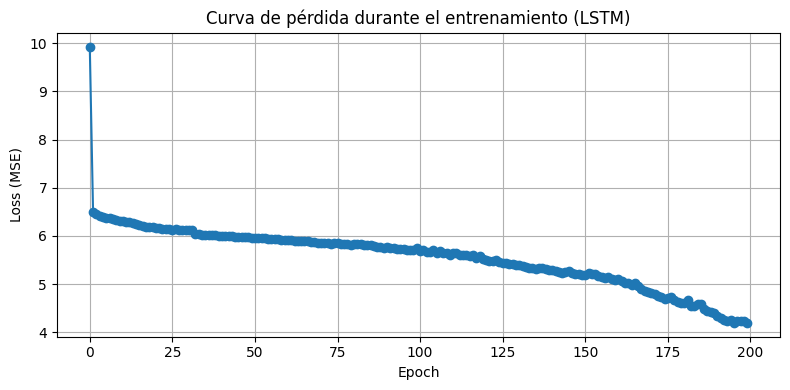

In [28]:
#Visualización curva loss vs. epoch
plt.figure(figsize=(8, 4))
plt.plot(loss_history, marker='o')
plt.title("Curva de pérdida durante el entrenamiento (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
model.eval()
lstm_preds, lstm_actuals = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb)
        lstm_preds.extend(out.view(-1).tolist())
        lstm_actuals.extend(yb.view(-1).tolist())

print("Random Forest:")
print(" R2:", r2_score(y_test, rf_preds), "MSE:", mean_squared_error(y_test, rf_preds))
print("Gradient Boosting:")
print(" R2:", r2_score(y_test, gb_preds), "MSE:", mean_squared_error(y_test, gb_preds))
print("LSTM:")
print(" R2:", r2_score(lstm_actuals, lstm_preds), "MSE:", mean_squared_error(lstm_actuals, lstm_preds))

Random Forest:
 R2: 0.8914582620268914 MSE: 0.17528229023004277
Gradient Boosting:
 R2: 0.9010329443016553 MSE: 0.15982029129133582
LSTM:
 R2: 0.24217236189253555 MSE: 7.657426625268143


In [38]:
# Crear la tabla de resultados
resultados = {
    "Modelo": ["Random Forest", "Gradient Boosting", "LSTM"],
    "R2": [0.8915, 0.9010, 0.2422],
    "MSE": [0.1753, 0.1598, 7.6574]
}

df_resultados = pd.DataFrame(resultados)

# Mostrar como tabla
print(df_resultados)

              Modelo      R2     MSE
0      Random Forest  0.8915  0.1753
1  Gradient Boosting  0.9010  0.1598
2               LSTM  0.2422  7.6574


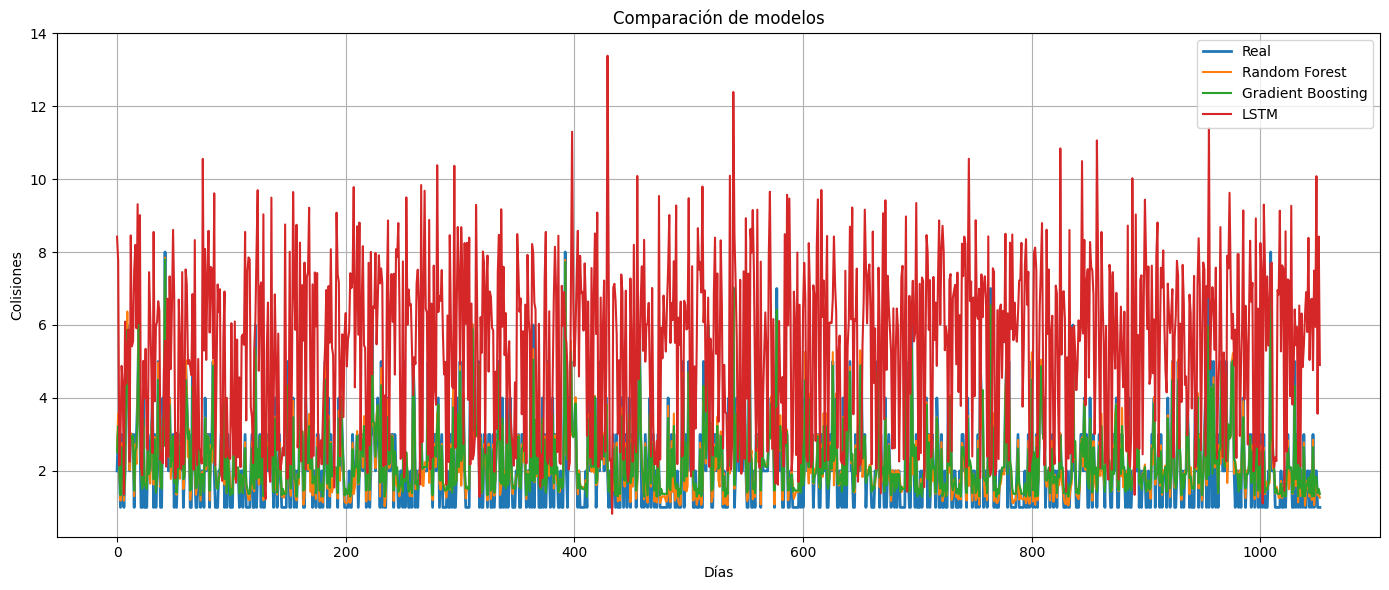

In [30]:
min_len = min(len(y_test), len(rf_preds), len(gb_preds), len(lstm_preds))
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[-min_len:], label='Real', linewidth=2)
plt.plot(rf_preds[-min_len:], label='Random Forest')
plt.plot(gb_preds[-min_len:], label='Gradient Boosting')
plt.plot(lstm_preds[-min_len:], label='LSTM')
plt.title("Comparación de modelos")
plt.xlabel("Días")
plt.ylabel("Colisiones")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


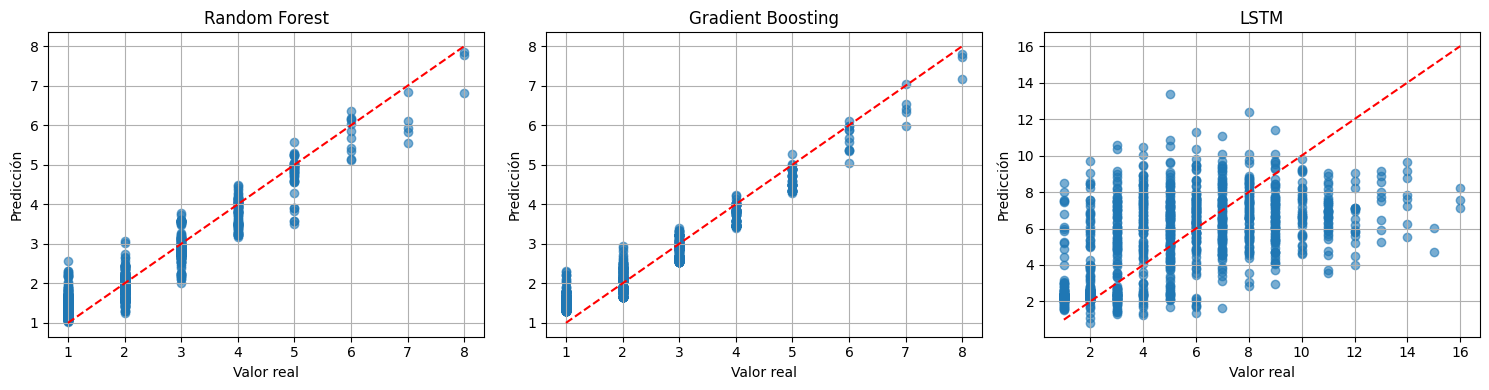

In [31]:
#Scatter plots

plt.figure(figsize=(15, 4))

# Random Forest
plt.subplot(1, 3, 1)
plt.scatter(y_test, rf_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal
plt.title("Random Forest")
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.grid(True)

# Gradient Boosting
plt.subplot(1, 3, 2)
plt.scatter(y_test, gb_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Gradient Boosting")
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.grid(True)

# LSTM
plt.subplot(1, 3, 3)
plt.scatter(lstm_actuals, lstm_preds, alpha=0.6)
plt.plot([min(lstm_actuals), max(lstm_actuals)], [min(lstm_actuals), max(lstm_actuals)], 'r--')
plt.title("LSTM")
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.grid(True)

plt.tight_layout()
plt.show()

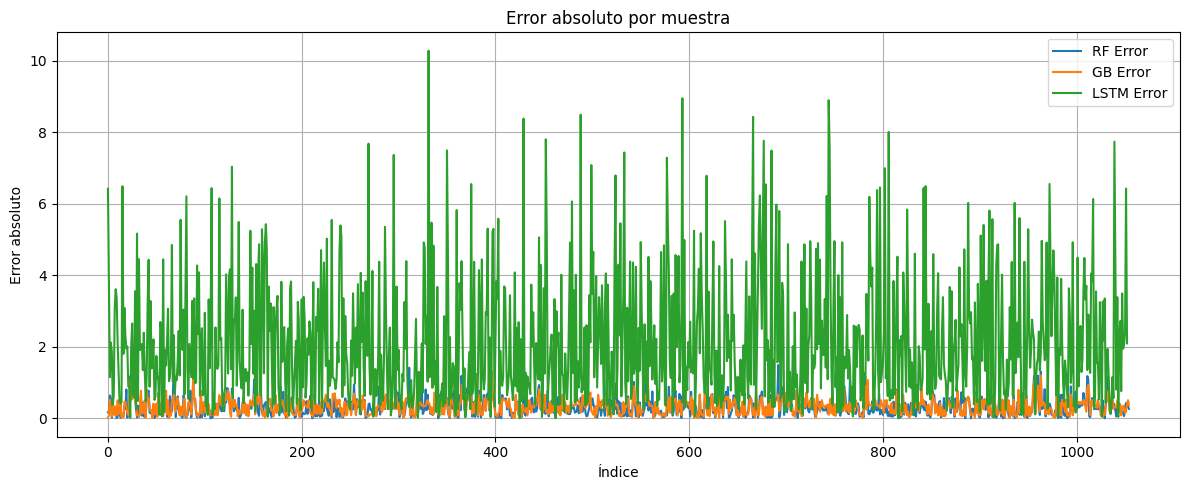

In [32]:
#Error absoluto
plt.figure(figsize=(12, 5))
plt.plot(np.abs(y_test.values - rf_preds), label='RF Error')
plt.plot(np.abs(y_test.values - gb_preds), label='GB Error')
plt.plot(np.abs(np.array(lstm_actuals) - np.array(lstm_preds)), label='LSTM Error')
plt.title("Error absoluto por muestra")
plt.xlabel("Índice")
plt.ylabel("Error absoluto")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

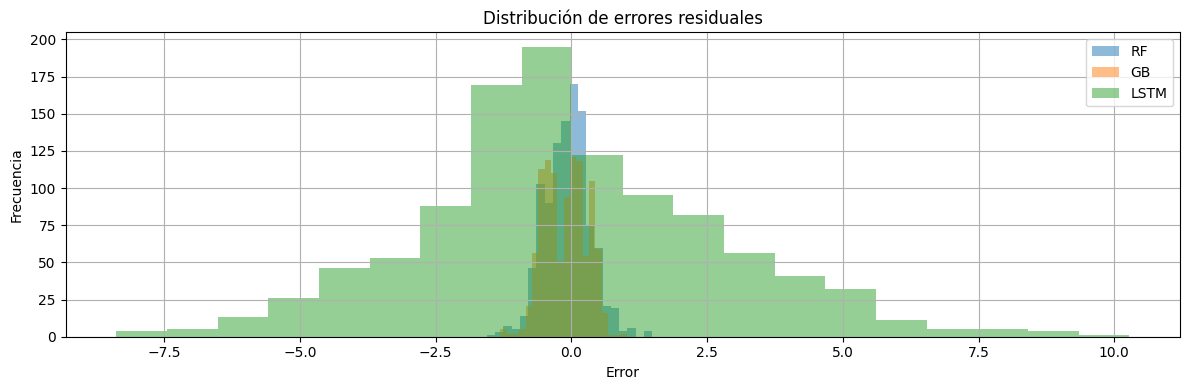

In [33]:
#Errores residuales
errors_rf = y_test.values - rf_preds
errors_gb = y_test.values - gb_preds
errors_lstm = np.array(lstm_actuals) - np.array(lstm_preds)

plt.figure(figsize=(12, 4))
plt.hist(errors_rf, bins=20, alpha=0.5, label="RF")
plt.hist(errors_gb, bins=20, alpha=0.5, label="GB")
plt.hist(errors_lstm, bins=20, alpha=0.5, label="LSTM")
plt.title("Distribución de errores residuales")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

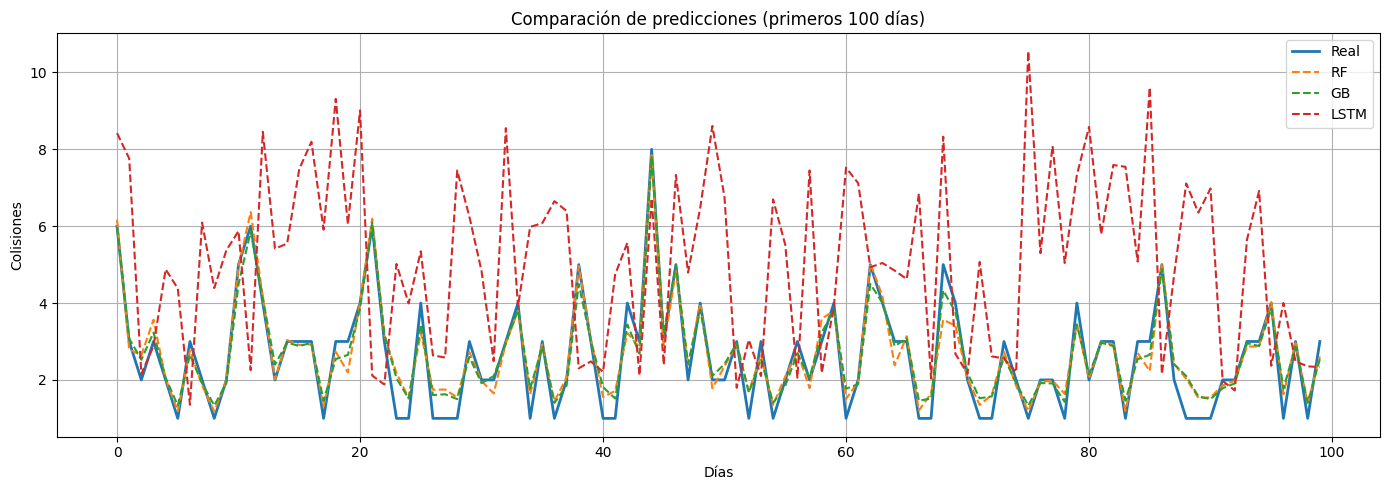

In [34]:
#Visualiozación con lineas
plt.figure(figsize=(14, 5))
plt.plot(y_test.values[:100], label="Real", linewidth=2)
plt.plot(rf_preds[:100], label="RF", linestyle='--')
plt.plot(gb_preds[:100], label="GB", linestyle='--')
plt.plot(lstm_preds[:100], label="LSTM", linestyle='--')
plt.title("Comparación de predicciones (primeros 100 días)")
plt.xlabel("Días")
plt.ylabel("Colisiones")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

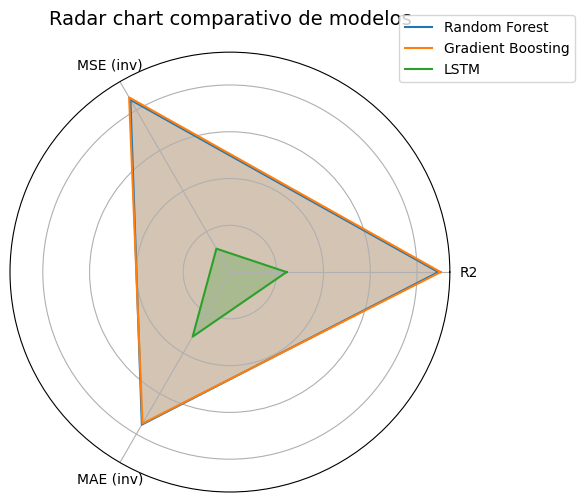

In [35]:
#Visualización mediante radar chart

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Métricas
metrics = {
    "Modelos": ["Random Forest", "Gradient Boosting", "LSTM"],
    "R2": [
        r2_score(y_test, rf_preds),
        r2_score(y_test, gb_preds),
        r2_score(lstm_actuals, lstm_preds)
    ],
    "MSE": [
        mean_squared_error(y_test, rf_preds),
        mean_squared_error(y_test, gb_preds),
        mean_squared_error(lstm_actuals, lstm_preds)
    ],
    "MAE": [
        mean_absolute_error(y_test, rf_preds),
        mean_absolute_error(y_test, gb_preds),
        mean_absolute_error(lstm_actuals, lstm_preds)
    ]
}

# Normalización inversa para que 1 sea mejor
r2_vals = metrics["R2"]
mse_vals = [1 / (1 + val) for val in metrics["MSE"]]
mae_vals = [1 / (1 + val) for val in metrics["MAE"]]

# Radar chart
labels = ['R2', 'MSE (inv)', 'MAE (inv)']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, modelo in enumerate(metrics["Modelos"]):
    values = [r2_vals[i], mse_vals[i], mae_vals[i]]
    values += values[:1]
    ax.plot(angles, values, label=modelo)
    ax.fill(angles, values, alpha=0.25)

ax.set_title("Radar chart comparativo de modelos", size=14, pad=20)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels([])
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

#Optimización de hiperparámetros para mejorar LSTM